In [1]:
#@title Code Lines with Header Styling
from IPython.display import display,HTML
from IPython.core.magic import register_line_magic
@register_line_magic
def cmap_header(params):
    params=params.split('|'); string=params[0]
    if len(params)==1: 
        font_size='20'; font_family='Ewert'; cmap='Sinebow'
    elif  len(params)==2: 
        font_size=params[1]; font_family='Ewert'; cmap='Sinebow'
    elif  len(params)==3: 
        font_size=params[1]; font_family=params[2]; cmap='Sinebow'
    else: 
        font_size=params[1]; font_family=params[2]; cmap=params[3]
    html_str="""
    <head><script src='https://d3js.org/d3.v6.min.js'></script></head>
    <style>@import 'https://fonts.googleapis.com/css?family="""+\
    font_family+"""&effect=3d'; #colorized {font-family:"""+font_family+"""; 
    color:white; padding-left:10px; font-size:"""+font_size+"""px;}</style>
    <h1 id='colorized' class='font-effect-3d'>"""+string+"""</h1>
    <script>
    var tc=setInterval(function(){
        var now=new Date().getTime();
        var iddoc=document.getElementById('colorized');
        iddoc.style.color=d3.interpolate"""+cmap+"""(now%(60000)/60000);},1)
    </script>"""
    display(HTML(html_str))

In [2]:
%cmap_header CODE MODULES & HELPFUL TOOLS

In [3]:
import tensorflow as tf,os,math,numpy as np
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
from tensorflow.keras.preprocessing.image import \
load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing import \
image_dataset_from_directory
from IPython.display import display
import pylab as pl,PIL
from mpl_toolkits.axes_grid1.inset_locator import \
zoomed_inset_axes,mark_inset

In [4]:
%cmap_header DATA LOADING

In [5]:
dataset_url='http://www.eecs.berkeley.edu/Research/'+\
            'Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'
data_dir=tf.keras.utils.get_file(
    origin=dataset_url,fname='BSR',untar=True)
root_dir=os.path.join(data_dir,'BSDS500/data')
data_path=os.path.join(root_dir,'images')
test_path=os.path.join(data_path,'test')
test_paths=sorted(
    [os.path.join(test_path,fname) 
    for fname in os.listdir(test_path)
    if fname.endswith('.jpg')])
test_paths[:3]

['/root/.keras/datasets/BSR/BSDS500/data/images/test/100007.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100039.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100099.jpg']

In [6]:
%cmap_header DATA PROCESSING

In [7]:
def scale01(img): return img/255
def process_input(input_rgb,img_size):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return tf.image.resize(y,[img_size,img_size],method='area')
def process_target(input_rgb):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return y  

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


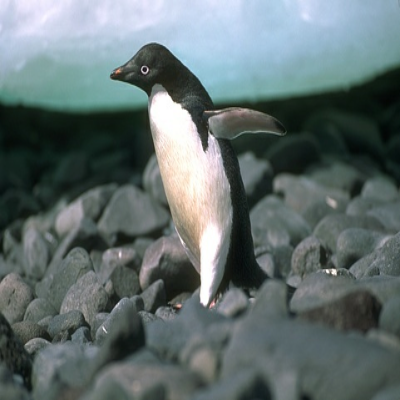

In [8]:
[crop_size,upscale_factor]=[400,4]
input_size=crop_size//upscale_factor
batch_size=8
train_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='training',
    seed=123,label_mode=None,)
valid_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='validation',
    seed=123,label_mode=None,)
train_ds=train_ds.map(scale01)
valid_ds=valid_ds.map(scale01)
for batch in train_ds.take(1):
    for img in batch: display(array_to_img(img)); break

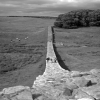

==> ==> ==> ==> ==> ==> ==> ==> ==> ==> 


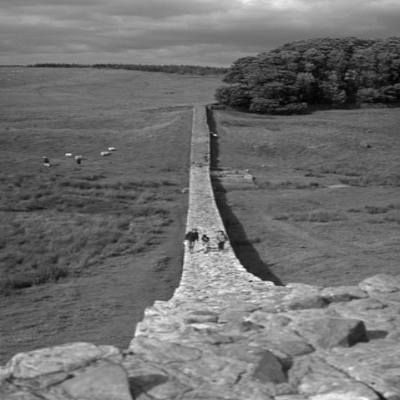

In [9]:
train_ds=train_ds.map(
    lambda x:(process_input(x,input_size),process_target(x)))
train_ds=train_ds.prefetch(buffer_size=16)
valid_ds=valid_ds.map(
    lambda x:(process_input(x,input_size),process_target(x)))
valid_ds=valid_ds.prefetch(buffer_size=16)
for batch in valid_ds.take(1):
    for img in batch[0]: display(array_to_img(img)); break
    print(10*'==> ')
    for img in batch[1]: display(array_to_img(img)); break

In [10]:
%cmap_header MODEL BUILDING

In [11]:
def model(upscale_factor=upscale_factor,channels=1):
    conv_args={'activation':'relu',
               'kernel_initializer':'Orthogonal',
               'padding':'same',}
    inputs=tf.keras.Input(shape=(None,None,channels))
 #   x=tkl.Conv2D(1024,5,**conv_args)(inputs)
 #   x=tkl.Conv2D(512,5,**conv_args)(inputs)
    x=tkl.Conv2D(256,5,**conv_args)(inputs)
    x=tkl.Conv2D(96,5,**conv_args)(x)
    x=tkl.Conv2D(32,3,**conv_args)(x)
    x=tkl.Conv2D(channels*(upscale_factor**2),3,**conv_args)(x)
    outputs=tf.nn.depth_to_space(x,upscale_factor)
    return tf.keras.Model(inputs,outputs)

In [12]:
%cmap_header CALLBACKS & PLOTTING

In [13]:
def display_results(img,prefix,title):
    img_array=img_to_array(img)
    img_array=img_array.astype('float32')/255
    fig,ax=pl.subplots()
    im=ax.imshow(img_array[::-1],origin='lower')
    pl.title(title)
    axins=zoomed_inset_axes(ax,2,loc=5)
    axins.imshow(img_array[::-1],origin='lower')
    x1,x2,y1,y2=200,300,100,200
    axins.set_xlim(x1,x2); axins.set_ylim(y1,y2)
    pl.yticks(visible=False); pl.xticks(visible=False)
    mark_inset(ax,axins,loc1=2,loc2=3,fc='none',ec='magenta')
    pl.savefig(str(prefix)+'_'+title+'.png')
    pl.show()
def low_resolution_img(img,upscale_factor):
    dimensions=(img.size[0]//upscale_factor,
                img.size[1]//upscale_factor)
    return img.resize(dimensions,PIL.Image.BICUBIC)
def upscale_img(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y).astype('float32')/255
    input_img=np.expand_dims(y,axis=0)
    out=model.predict(input_img)
    out_img_y=out[0]*255.
    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape(
        (np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge(
        'YCbCr',(out_img_y,out_img_cb,out_img_cr))
    return out_img.convert('RGB')

In [14]:
class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback,self).__init__()
        self.test_img=low_resolution_img(
            load_img(test_paths[0]),upscale_factor)
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
    def on_epoch_end(self,epoch,logs=None):
        print('mean PSNR for epoch: %.2f'%(np.mean(self.psnr)))
        if epoch%25==0:
            prediction=upscale_img(self.model,self.test_img)
            display_results(
                prediction,'epoch-'+str(epoch),'prediction')
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs['loss']))

In [15]:
early_stopping=tkc.EarlyStopping(monitor='loss',patience=10)
checkpoint_path='/tmp/checkpoint'
checkpoint=tkc.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    monitor='loss',mode='min',save_best_only=True,verbose=2)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',patience=10,verbose=2,factor=.9)

In [16]:
%cmap_header MODEL COMPILING & TRAINING

In [17]:
model=model(upscale_factor=upscale_factor,channels=1)
model.summary()
callbacks=[ESPCNCallback(),early_stopping,checkpoint,lr_reduction]
loss_fn=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(learning_rate=.001)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 256)   6656      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 96)    614496    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    27680     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 653,456
Trainable params: 653,456
Non-trainable params: 0
_______________________________________________________

Epoch 1/300
50/50 - 6s - loss: 0.0276 - val_loss: 0.0073
mean PSNR for epoch: 21.59


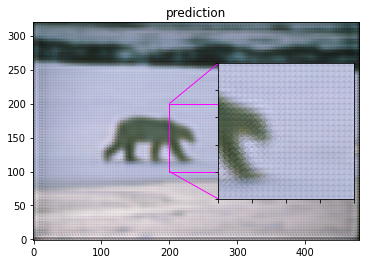


Epoch 00001: loss improved from inf to 0.02758, saving model to /tmp/checkpoint
Epoch 2/300
50/50 - 4s - loss: 0.0051 - val_loss: 0.0045
mean PSNR for epoch: 23.61

Epoch 00002: loss improved from 0.02758 to 0.00505, saving model to /tmp/checkpoint
Epoch 3/300
50/50 - 4s - loss: 0.0039 - val_loss: 0.0042
mean PSNR for epoch: 23.75

Epoch 00003: loss improved from 0.00505 to 0.00393, saving model to /tmp/checkpoint
Epoch 4/300
50/50 - 4s - loss: 0.0034 - val_loss: 0.0035
mean PSNR for epoch: 24.65

Epoch 00004: loss improved from 0.00393 to 0.00336, saving model to /tmp/checkpoint
Epoch 5/300
50/50 - 4s - loss: 0.0031 - val_loss: 0.0033
mean PSNR for epoch: 24.68

Epoch 00005: loss improved from 0.00336 to 0.00311, saving model to /tmp/checkpoint
Epoch 6/300
50/50 - 4s - loss: 0.0029 - val_loss: 0.0032
mean PSNR for epoch: 24.92

Epoch 00006: loss improved from 0.00311 to 0.00294, saving model to /tmp/checkpoint
Epoch 7/300
50/50 - 4s - loss: 0.0029 - val_loss: 0.0032
mean PSNR for epo

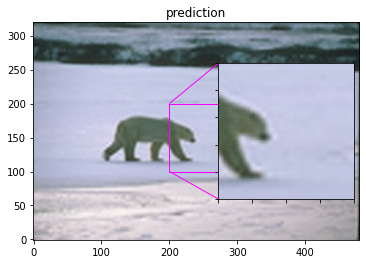


Epoch 00026: loss did not improve from 0.00254
Epoch 27/300
50/50 - 4s - loss: 0.0026 - val_loss: 0.0032
mean PSNR for epoch: 24.92

Epoch 00027: loss did not improve from 0.00254
Epoch 28/300
50/50 - 4s - loss: 0.0027 - val_loss: 0.0031
mean PSNR for epoch: 25.11

Epoch 00028: loss did not improve from 0.00254
Epoch 29/300
50/50 - 4s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.27

Epoch 00029: loss improved from 0.00254 to 0.00253, saving model to /tmp/checkpoint
Epoch 30/300
50/50 - 4s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.46

Epoch 00030: loss improved from 0.00253 to 0.00250, saving model to /tmp/checkpoint
Epoch 31/300
50/50 - 4s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.67

Epoch 00031: loss improved from 0.00250 to 0.00250, saving model to /tmp/checkpoint
Epoch 32/300
50/50 - 4s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.59

Epoch 00032: loss did not improve from 0.00250
Epoch 33/300
50/50 - 4s - loss: 0.0025 - va

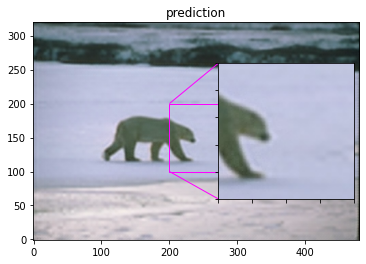


Epoch 00051: loss did not improve from 0.00242
Epoch 52/300
50/50 - 4s - loss: 0.0025 - val_loss: 0.0027
mean PSNR for epoch: 25.54

Epoch 00052: loss did not improve from 0.00242
Epoch 53/300
50/50 - 4s - loss: 0.0024 - val_loss: 0.0029
mean PSNR for epoch: 25.51

Epoch 00053: loss did not improve from 0.00242
Epoch 54/300
50/50 - 4s - loss: 0.0025 - val_loss: 0.0027
mean PSNR for epoch: 25.88

Epoch 00054: loss did not improve from 0.00242
Epoch 55/300
50/50 - 4s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.84

Epoch 00055: loss did not improve from 0.00242
Epoch 56/300
50/50 - 4s - loss: 0.0026 - val_loss: 0.0028
mean PSNR for epoch: 25.55

Epoch 00056: loss did not improve from 0.00242

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.
Epoch 57/300
50/50 - 4s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.65

Epoch 00057: loss improved from 0.00242 to 0.00242, saving model to /tmp/checkpoint
Epoch 58/300
50/50 - 4s - loss: 0.00

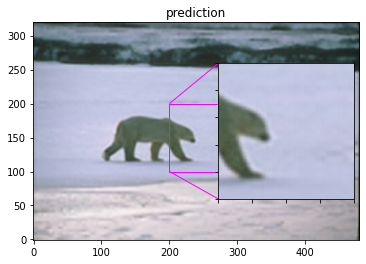


Epoch 00076: loss did not improve from 0.00237

Epoch 00076: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 77/300
50/50 - 4s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.60

Epoch 00077: loss improved from 0.00237 to 0.00236, saving model to /tmp/checkpoint
Epoch 78/300
50/50 - 4s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.73

Epoch 00078: loss improved from 0.00236 to 0.00236, saving model to /tmp/checkpoint
Epoch 79/300
50/50 - 4s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.35

Epoch 00079: loss improved from 0.00236 to 0.00236, saving model to /tmp/checkpoint
Epoch 80/300
50/50 - 4s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.64

Epoch 00080: loss did not improve from 0.00236
Epoch 81/300
50/50 - 4s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.92

Epoch 00081: loss improved from 0.00236 to 0.00236, saving model to /tmp/checkpoint
Epoch 82/300
50/50 - 4s - loss: 0.0024 - val_loss: 0.0027


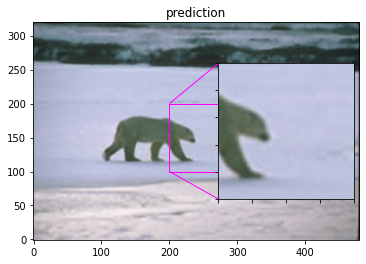


Epoch 00101: loss improved from 0.00233 to 0.00233, saving model to /tmp/checkpoint
Epoch 102/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.49

Epoch 00102: loss did not improve from 0.00233
Epoch 103/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.92

Epoch 00103: loss did not improve from 0.00233
Epoch 104/300
50/50 - 4s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.24

Epoch 00104: loss did not improve from 0.00233
Epoch 105/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 26.00

Epoch 00105: loss improved from 0.00233 to 0.00233, saving model to /tmp/checkpoint
Epoch 106/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.56

Epoch 00106: loss improved from 0.00233 to 0.00232, saving model to /tmp/checkpoint

Epoch 00106: ReduceLROnPlateau reducing learning rate to 0.0004304672533180565.
Epoch 107/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.80

Epo

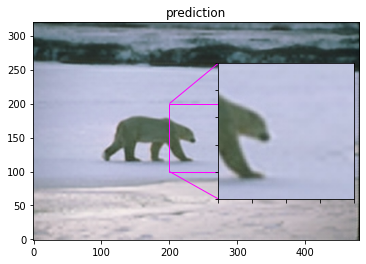


Epoch 00126: loss did not improve from 0.00230

Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.0003486784757114947.
Epoch 127/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.82

Epoch 00127: loss did not improve from 0.00230
Epoch 128/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.54

Epoch 00128: loss improved from 0.00230 to 0.00230, saving model to /tmp/checkpoint
Epoch 129/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.73

Epoch 00129: loss improved from 0.00230 to 0.00230, saving model to /tmp/checkpoint
Epoch 130/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.66

Epoch 00130: loss did not improve from 0.00230
Epoch 131/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.85

Epoch 00131: loss did not improve from 0.00230
Epoch 132/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.79

Epoch 00132: loss improved from 0.00230 

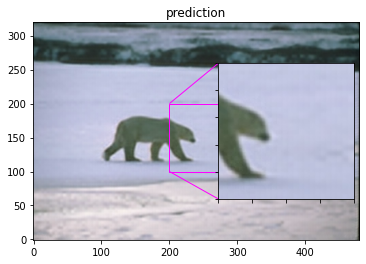


Epoch 00151: loss improved from 0.00228 to 0.00228, saving model to /tmp/checkpoint
Epoch 152/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.74

Epoch 00152: loss did not improve from 0.00228
Epoch 153/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.66

Epoch 00153: loss improved from 0.00228 to 0.00228, saving model to /tmp/checkpoint
Epoch 154/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 26.06

Epoch 00154: loss did not improve from 0.00228
Epoch 155/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.84

Epoch 00155: loss did not improve from 0.00228
Epoch 156/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.78

Epoch 00156: loss improved from 0.00228 to 0.00228, saving model to /tmp/checkpoint

Epoch 00156: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
Epoch 157/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.85

Ep

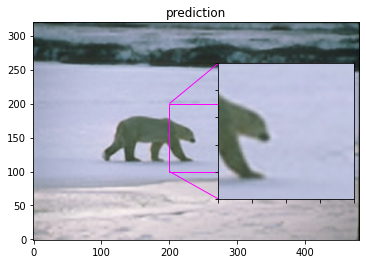


Epoch 00176: loss did not improve from 0.00227

Epoch 00176: ReduceLROnPlateau reducing learning rate to 0.00020589114428730683.
Epoch 177/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.93

Epoch 00177: loss improved from 0.00227 to 0.00227, saving model to /tmp/checkpoint
Epoch 178/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 26.36

Epoch 00178: loss improved from 0.00227 to 0.00226, saving model to /tmp/checkpoint
Epoch 179/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.97

Epoch 00179: loss improved from 0.00226 to 0.00226, saving model to /tmp/checkpoint
Epoch 180/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.47

Epoch 00180: loss did not improve from 0.00226
Epoch 181/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.68

Epoch 00181: loss improved from 0.00226 to 0.00226, saving model to /tmp/checkpoint
Epoch 182/300
50/50 - 4s - loss: 0.0023 - val_loss: 

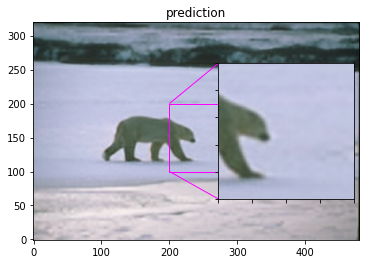


Epoch 00201: loss improved from 0.00225 to 0.00225, saving model to /tmp/checkpoint
Epoch 202/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 26.10

Epoch 00202: loss improved from 0.00225 to 0.00225, saving model to /tmp/checkpoint
Epoch 203/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 26.07

Epoch 00203: loss did not improve from 0.00225
Epoch 204/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.90

Epoch 00204: loss did not improve from 0.00225
Epoch 205/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.35

Epoch 00205: loss did not improve from 0.00225
Epoch 206/300
50/50 - 4s - loss: 0.0023 - val_loss: 0.0026
mean PSNR for epoch: 25.29

Epoch 00206: loss did not improve from 0.00225
Epoch 207/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.94

Epoch 00207: loss did not improve from 0.00225
Epoch 208/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for e

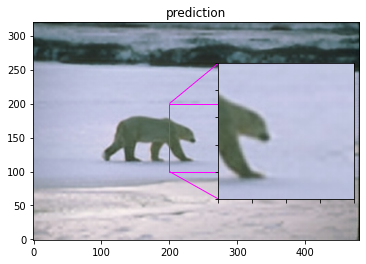


Epoch 00226: loss improved from 0.00224 to 0.00224, saving model to /tmp/checkpoint
Epoch 227/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.62

Epoch 00227: loss did not improve from 0.00224
Epoch 228/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 26.10

Epoch 00228: loss did not improve from 0.00224
Epoch 229/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.97

Epoch 00229: loss improved from 0.00224 to 0.00224, saving model to /tmp/checkpoint
Epoch 230/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.42

Epoch 00230: loss improved from 0.00224 to 0.00224, saving model to /tmp/checkpoint

Epoch 00230: ReduceLROnPlateau reducing learning rate to 0.00012157666351413355.
Epoch 231/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 26.04

Epoch 00231: loss improved from 0.00224 to 0.00224, saving model to /tmp/checkpoint
Epoch 232/300
50/50 - 4s - loss: 0.0022 - val_loss: 

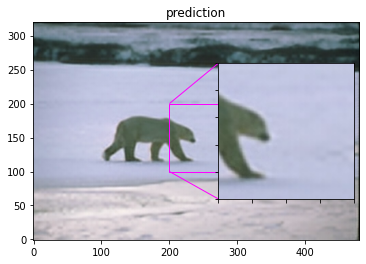


Epoch 00251: loss did not improve from 0.00223
Epoch 252/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.81

Epoch 00252: loss improved from 0.00223 to 0.00223, saving model to /tmp/checkpoint
Epoch 253/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 26.11

Epoch 00253: loss did not improve from 0.00223
Epoch 254/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.60

Epoch 00254: loss did not improve from 0.00223
Epoch 255/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.87

Epoch 00255: loss did not improve from 0.00223
Epoch 256/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.61

Epoch 00256: loss improved from 0.00223 to 0.00223, saving model to /tmp/checkpoint
Epoch 257/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.86

Epoch 00257: loss did not improve from 0.00223
Epoch 258/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for e

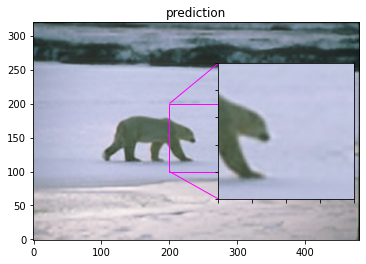


Epoch 00276: loss did not improve from 0.00222
Epoch 277/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.41

Epoch 00277: loss improved from 0.00222 to 0.00222, saving model to /tmp/checkpoint
Epoch 278/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 26.04

Epoch 00278: loss did not improve from 0.00222
Epoch 279/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.54

Epoch 00279: loss improved from 0.00222 to 0.00222, saving model to /tmp/checkpoint
Epoch 280/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 26.12

Epoch 00280: loss improved from 0.00222 to 0.00222, saving model to /tmp/checkpoint

Epoch 00280: ReduceLROnPlateau reducing learning rate to 7.178980231401511e-05.
Epoch 281/300
50/50 - 4s - loss: 0.0022 - val_loss: 0.0026
mean PSNR for epoch: 25.77

Epoch 00281: loss improved from 0.00222 to 0.00222, saving model to /tmp/checkpoint
Epoch 282/300
50/50 - 4s - loss: 0.0022 - val_loss: 0

In [18]:
epochs=300
model.compile(optimizer=optimizer,loss=loss_fn,)
history=model.fit(
    train_ds,epochs=epochs,callbacks=callbacks,
    validation_data=valid_ds,verbose=2)
model.load_weights(checkpoint_path)

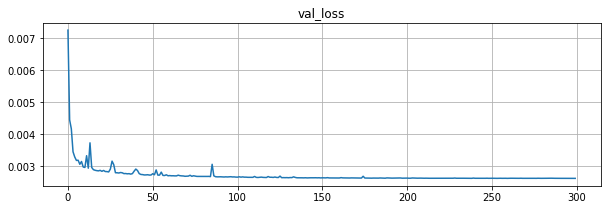

In [19]:
history_keys=list(history.history.keys())
pl.figure(figsize=(10,3))
pl.plot(history.history[history_keys[1]])
pl.grid(); pl.title(history_keys[1]);

In [20]:
%cmap_header TEST RESULTS

PSNR of low resolution and high resolution is 21.9522
PSNR of predict and high resolution is 22.6429


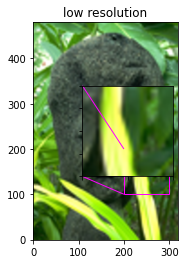

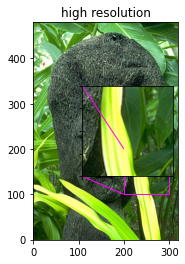

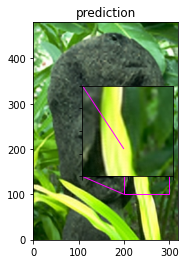

PSNR of low resolution and high resolution is 20.5894
PSNR of predict and high resolution is 20.9638


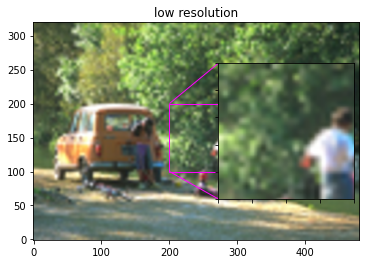

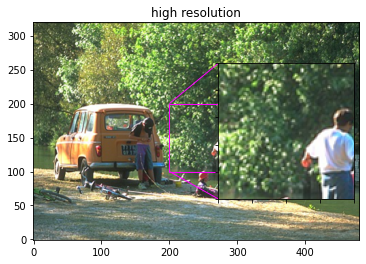

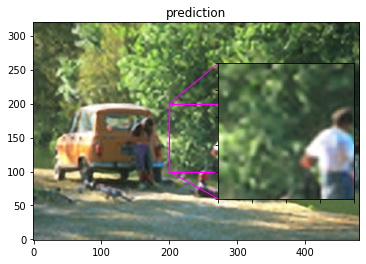

PSNR of low resolution and high resolution is 22.6938
PSNR of predict and high resolution is 23.4630


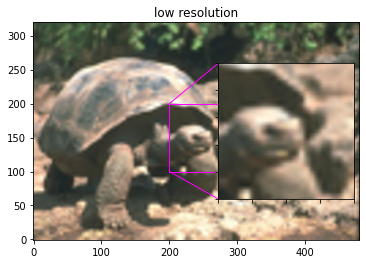

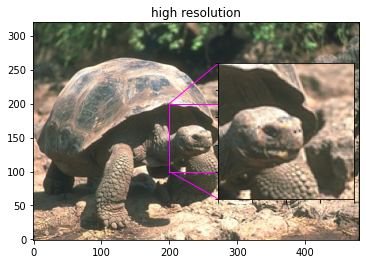

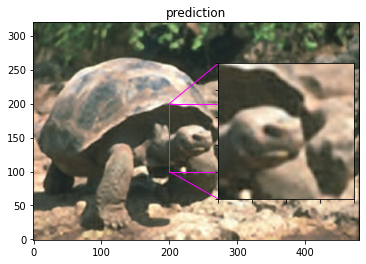

PSNR of low resolution and high resolution is 32.0279
PSNR of predict and high resolution is 33.1177


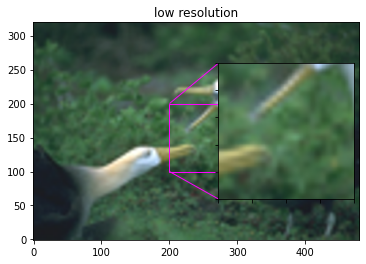

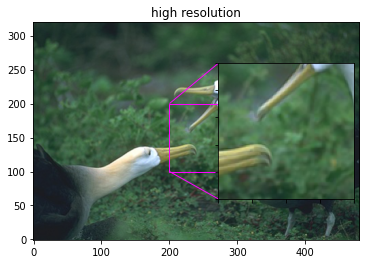

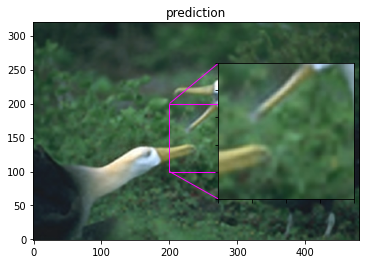

PSNR of low resolution and high resolution is 25.4892
PSNR of predict and high resolution is 26.2219


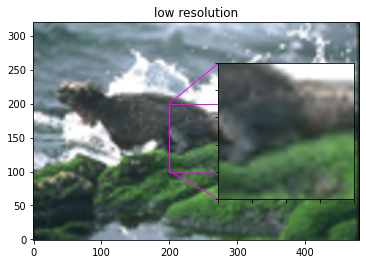

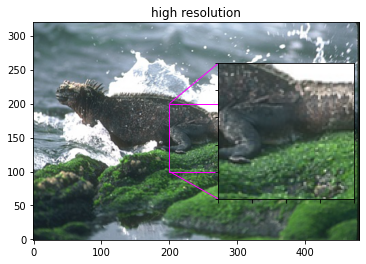

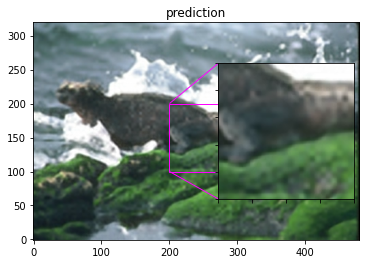

PSNR of low resolution and high resolution is 26.6017
PSNR of predict and high resolution is 27.1369


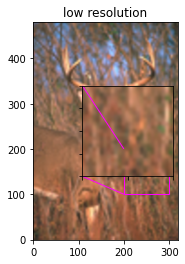

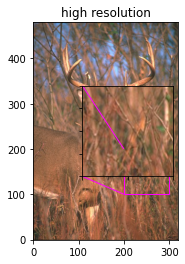

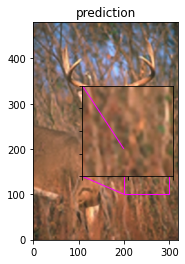

PSNR of low resolution and high resolution is 30.3825
PSNR of predict and high resolution is 30.7442


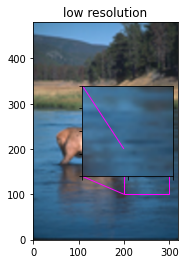

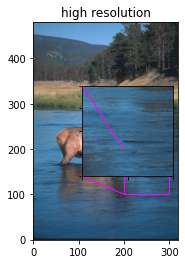

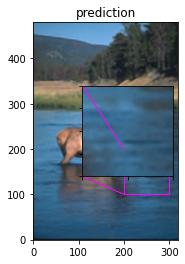

PSNR of low resolution and high resolution is 27.5683
PSNR of predict and high resolution is 28.0900


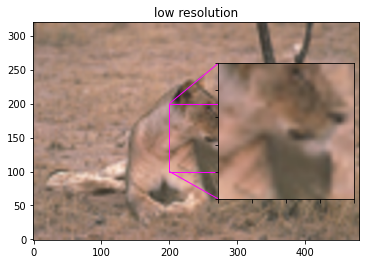

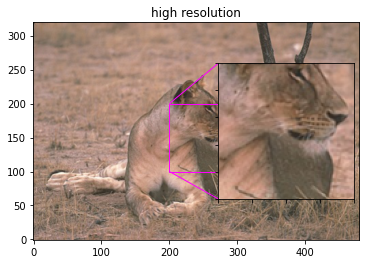

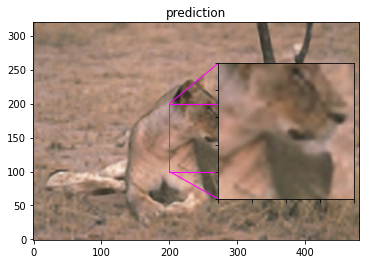

PSNR of low resolution and high resolution is 31.4097
PSNR of predict and high resolution is 32.5151


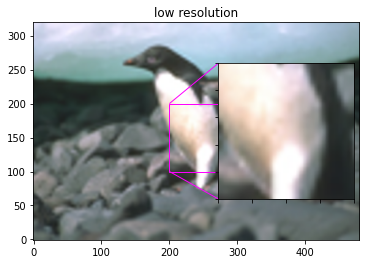

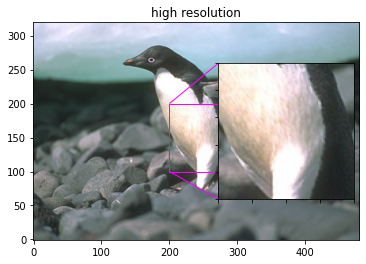

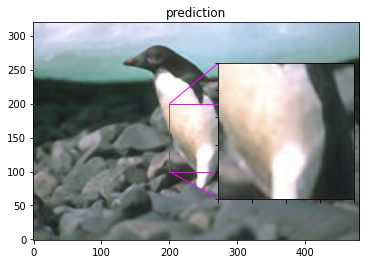

PSNR of low resolution and high resolution is 29.9933
PSNR of predict and high resolution is 30.9917


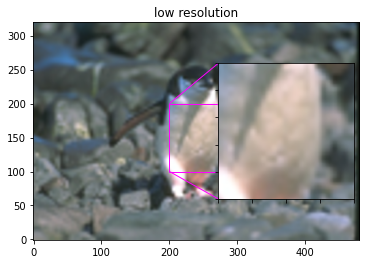

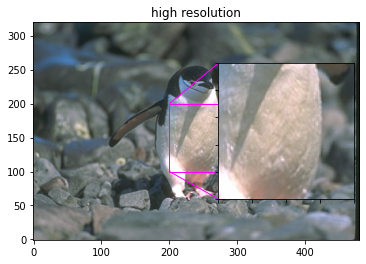

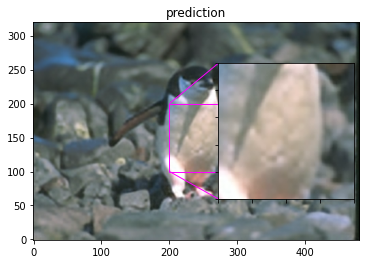

avg. PSNR of images with low resolution is 26.8708
avg. PSNR of reconstructions is 27.5887


In [21]:
total_bicubic_psnr=0.; total_test_psnr=0.
for index,test_path in enumerate(test_paths[5:15]):
    img=load_img(test_path)
    lowres_input=low_resolution_img(img,upscale_factor)
    w=lowres_input.size[0]*upscale_factor
    h=lowres_input.size[1]*upscale_factor
    highres_img=img.resize((w,h))
    predict_img=upscale_img(model,lowres_input)
    lowres_img=lowres_input.resize((w,h))
    lowres_img_arr=img_to_array(lowres_img)
    highres_img_arr=img_to_array(highres_img)
    predict_img_arr=img_to_array(predict_img)
    bicubic_psnr=tf.image.psnr(
        lowres_img_arr,highres_img_arr,max_val=255)
    test_psnr=tf.image.psnr(
        predict_img_arr,highres_img_arr,max_val=255)
    total_bicubic_psnr+=bicubic_psnr
    total_test_psnr+=test_psnr
    print('PSNR of low resolution '+\
          'and high resolution is %.4f'%bicubic_psnr)
    print('PSNR of predict and high resolution is %.4f'%test_psnr)
    display_results(lowres_img,index,'low resolution')
    display_results(highres_img,index,'high resolution')
    display_results(predict_img,index,'prediction')
print('avg. PSNR of images with low resolution is %.4f'\
      %(total_bicubic_psnr/10))
print('avg. PSNR of reconstructions is %.4f'\
      %(total_test_psnr/10))